# DSCI Group Project Proposal

#### By Ryan Seo, Michael Woolsey, Jianru Deng, Sidharth Grover

## Introduction

Tennis is a competitive racket sport played individually (singles) or in pairs (doubles). Players take turn serving the ball, players earn a point everytime the other player fails to return the ball. The score is kept using a game/set/match system, and games are usually played in a best of 3 or 5. The court has 3 main types of surfaces: hard, clay, and grass.

The game has evolved from the wooden-racket era of long, crafty points based on style and finesse to the modern fast-paced game based on strength, power, and agility. This development over the last 20 years has led to an increased interest in tennis game outcome analysis.

### Question
"What is the best combination of the variables in our data that produces the most accurate model in predicting the length of games in a best of 3 series?"

### Evaluating the data set
The dataset includes most professional tennis matches played in the years 2017-2019, with data provided by the Association of Tennis Professionals (ATP) and compiled by gitHub user JeffSackmann. The data has every individual game as an observation, with player details (ie. name and age), tournament details (ie. place, time, court type), and game details (ie. score, minutes, # of aces) for each observation. The winners and losers are also indicated for each observation, meaning most the game stats are duplicated for the winner and loser.

Source: https://github.com/JeffSackmann/tennis_atp

## Preliminary Exploratory Data Analysis
#### Loading Libraries

In [2]:
library(tidyverse)
library(repr)
library(caret)
library(RColorBrewer)
library(GGally)
install.packages('e1071', dependencies = TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

also installing the dependencies ‘cluster’, ‘mlbench’, ‘SparseM’, ‘slam’

Warning message in install.packages("e1071", dependencies = TRUE):
“installation of package ‘e1071’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


#### Loading Data from Source

In [3]:
data <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(data)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)
See spec(...) for full column specifications.


X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


### Explaining Data Wrangling & Cleaning Process

In order to split our data into training and testing sets, we needed to figure out what should be our classification variable. Our question indicates that our predicted variable is the length of game time. However, because the variable 'minutes' is not categorical, we needed to divide the game time into intervals. We did this by arranging our data by the minutes and then finding the number of total observations. Diving this amount by 5 gave us the amount of observations that would go into each class, as shown below. 

In addition, the sourced data set includes best-of-3 and best-of-5 tennis matches. Since these matches would obvious show drastic difference in game time, all best-of-5 matches were ommited for the purpose of this analysis. 

In [4]:
data_sorted <- data %>% 
    arrange(minutes) %>% #Sorts the data in ascending order of minutes
    filter(best_of == 3) %>% #The data will only include best of 3 for the purpose of analysis
    tibble::rowid_to_column("ID") #adds column for index

amount <- summarize(data_sorted, max(ID)) #Calculates number of observations
amount = amount / 5
amount # This is the number to divide by, to create as even spread of observations as possible


max(ID)
<dbl>
1097.2


In [5]:
data_sorted <- data_sorted %>% 
    mutate(time_classifier = as.factor(ceiling(ID/1097.2))) #Adds the classes as a factor into the data table
    
data_sorted_grouped <- data_sorted %>% #This table was made for the purpose of visualization as shown below
    group_by(minutes, time_classifier) %>%
    summarize(n = n())

tail(data_sorted_grouped)

minutes,time_classifier,n
<dbl>,<fct>,<int>
208,5,1
216,5,1
219,5,1
289,5,1
987,5,1
NA,5,113


The grouped data gives us two interesting pieces of information. First, there are 113 empty observations, which will omit for analysis. Second, there is a clear outlier shown at the end, with a value of minutes = 987. Considering our data set had 5000+ observations, and no other match lasted over 289 minutes, it made sense to remove this outlier for both analytical and aesthetical purposes. Considering the number of total observations, this outlier wouldn't make a huge difference, but the outlier was so noticable that it was done regardless. The data frame needs to be classified again to take account this new information, which is done below. 

In [6]:
data_sorted <- data %>% 
    arrange(minutes) %>%
    filter(best_of == 3) %>% 
    filter(minutes < 300) %>% 
    tibble::rowid_to_column("ID")

amount <- summarize(data_sorted, max(ID)) 
amount = amount / 5 # This is our NEW number to divide by, giving even splits for classification

data_sorted <- data_sorted %>% 
    mutate(time_classifier = as.factor(ceiling(ID/1074.4))) # Our new number 
    
data_sorted_grouped <- data_sorted %>% 
    group_by(minutes, time_classifier) %>%
    summarize(n = n())

tail(data_sorted_grouped)

minutes,time_classifier,n
<dbl>,<fct>,<int>
200,5,1
202,5,1
208,5,1
216,5,1
219,5,1
289,5,1


We can use the table below to confirm that there is an equal distribution of observations for each class. 

In [7]:
class_split_table <- data_sorted %>% 
    #filter(minutes < 300) %>%
    group_by(time_classifier) %>% 
    summarize(n = n())
class_split_table


time_classifier,n
<fct>,<int>
1,1074
2,1074
3,1075
4,1074
5,1075


The minute_plot shows how the minutes are distributed, and how the classes are divided as a result.

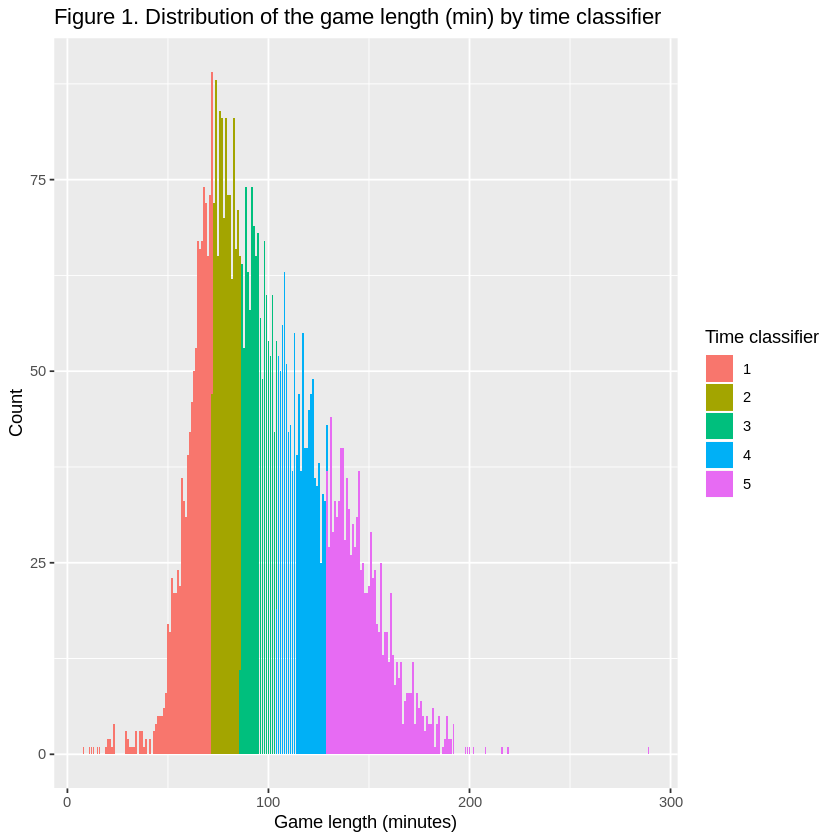

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)
minute_plot <-
    ggplot(data_sorted_grouped, aes(x=minutes, y=n,fill=time_classifier)) +
    geom_bar(stat='identity')+
    labs(x='Game length (minutes)',y='Count',fill='Time classifier')+
    ggtitle('Figure 1. Distribution of the game length (min) by time classifier')
minute_plot

### Evaluating Our Data Set Before Classification

Now, we can move onto the classification analysis. However, it is important recognize the type of data that exists in the data set, and which ones are relevant for analysis. In our case, we can divide each match into for types of variables: The winner's player profile (age, height, rank, etc), loser's player profile, winner's game stats (serves, aces, score, etc.) and loser's game stats. In our hypothesis, we predicted that the player profiles would be better indicators of game time than the actual game stats. To test our hypothesis, it makes sense to perform two classification analyses: One to find the best predictors out of the game stats, and one to test the best predictors out of the player profiles. After this is done, we will compare the two models and determine which is superior.  

## Classification Analysis A: Game Stats

### Determining the Best Qualifiers 

To do this, we filtered out our data set by the game stats, and then used ggpairs to find the best correlations with time_classifier. Since there are a great number of game data columns, we splitted the ggpairs analysis into the winner and loser stats. 

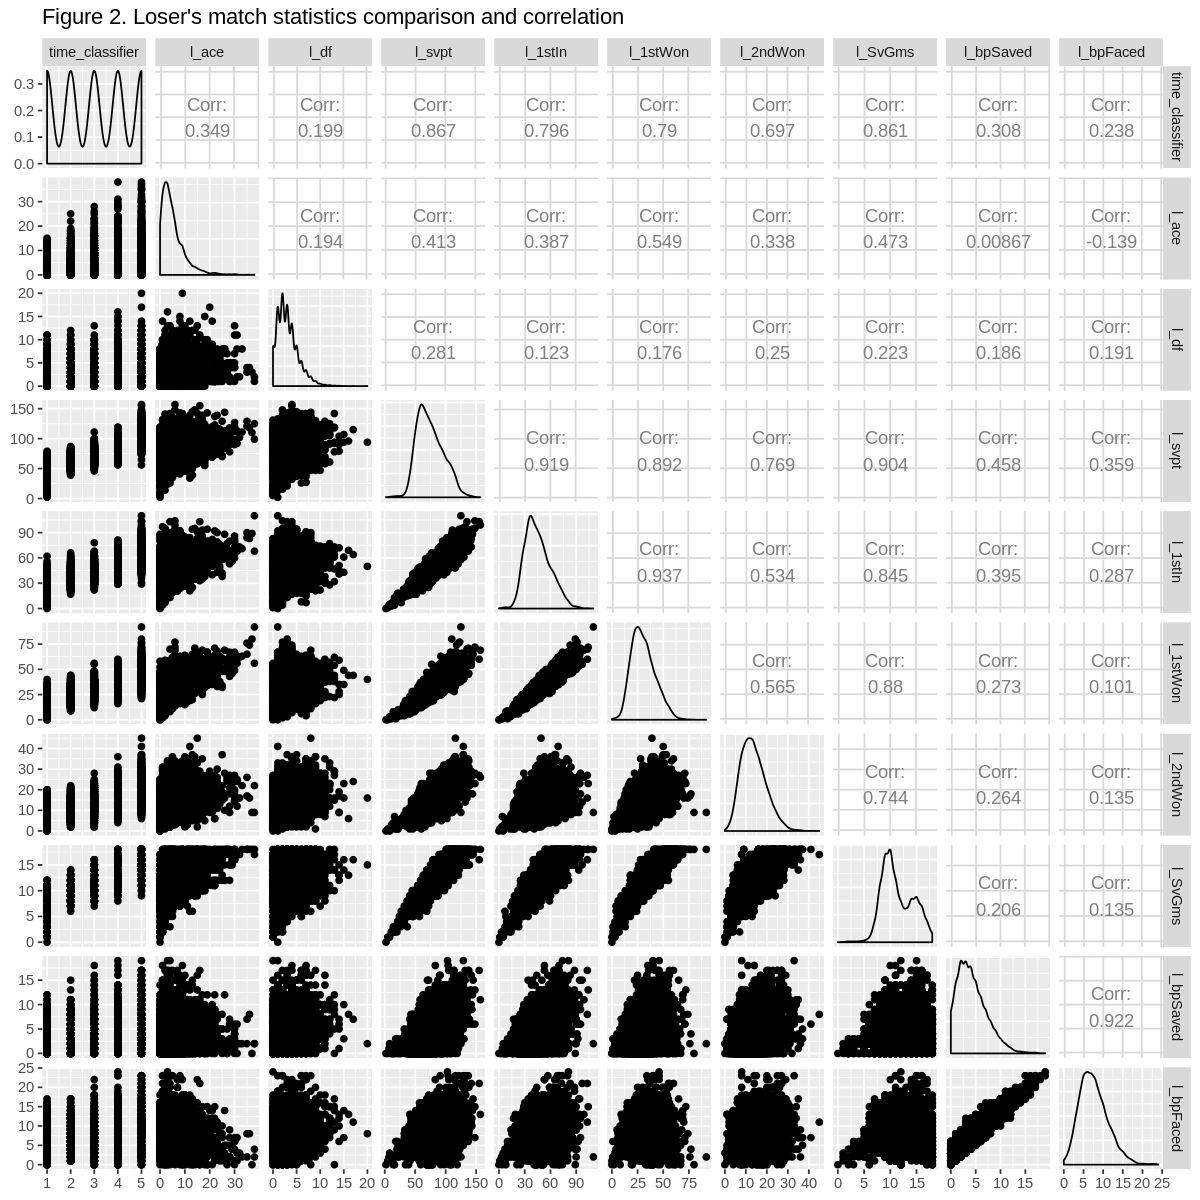

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_pairs_loser <- data_sorted %>% # use ggpairs to plot loser statistics with time_classifier
    mutate(time_classifier = as.numeric(time_classifier)) %>%
    select(time_classifier, l_ace, l_df, l_svpt, l_1stIn, l_1stWon, l_2ndWon,
           l_SvGms, l_bpSaved, l_bpFaced) %>%
    ggpairs(options(warn = -1)) + ggtitle("Figure 2. Loser's match statistics comparison and correlation")

plot_pairs_loser

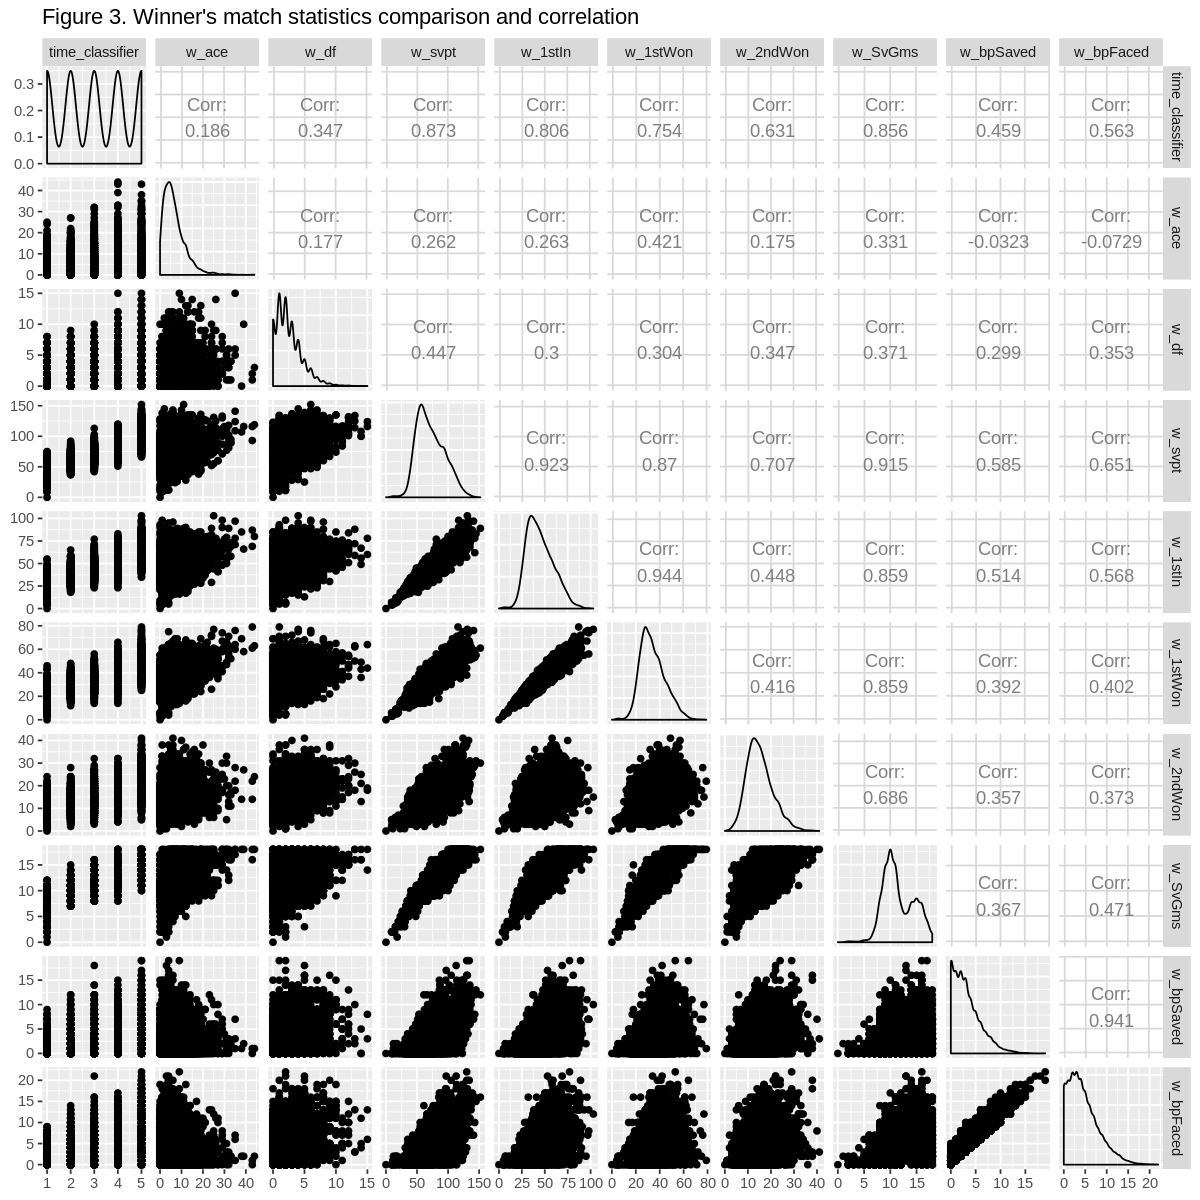

In [15]:
plot_pairs_winner <- data_sorted %>% # use ggpairs to plot winner stats with time_classifier
    mutate(time_classifier = as.numeric(time_classifier)) %>%
    select(time_classifier, w_ace, w_df, w_svpt, w_1stIn, w_1stWon, w_2ndWon,
           w_SvGms, w_bpSaved, w_bpFaced) %>%
    ggpairs(options(warn = -1)) + ggtitle("Figure 3. Winner's match statistics comparison and correlation")

plot_pairs_winner

#### Evaluation of ggpairs

Based on Figure 2 and 3, comparing each variable with time_classifier showed that `w_svpt, w_SvGms, l_svpt, l_SvGms` had the highest correlation coefficient values. `w_svpt` indicates the winner's number of serves, `w_SvGms` is for the number of service games played for the winner, and `l_svpt` & `l_SvGms` represent the same things, but just for the match's loser. These will be used as classifiers for the knn-classification model. 

### Creating the training set and the testing set
Now that we have our class variable set up, we can split our data into training and testing sets. 
We did this by creating a partition, splitting the data into 75:25, for training and testing observations respectively. 

In [16]:
set.seed(1000) #makes the random selection of rows reproducible

head(data_sorted)
set_rows <- data_sorted %>%
    select(time_classifier) %>%
    unlist() %>%
    createDataPartition(p = 0.75, list = FALSE)

training_set <- data_sorted %>% slice(set_rows)
test_set <- data_sorted %>% slice(-set_rows)

ID,X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,⋯,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,time_classifier
<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2612,2017-0329,Tokyo,Hard,32,A,20171002,291,105216,⋯,3,0,1,2,3,40,1127,12,2825,1
2,1095,2017-0410,Monte Carlo Masters,Clay,64,M,20170417,290,106298,⋯,1,1,1,1,2,17,2306,56,816,1
3,2650,2017-5014,Shanghai Masters,Hard,64,M,20171009,274,100644,⋯,2,2,2,0,2,4,4400,48,968,1
4,2775,2017-0328,Basel,Hard,32,A,20171023,287,105916,⋯,0,1,1,0,1,100,537,52,897,1
5,522,2018-0407,Rotterdam,Hard,32,A,20180212,279,105732,⋯,3,3,2,0,1,80,690,33,1375,1
6,1011,2018-0360,Marrakech,Clay,32,A,20180409,270,106378,⋯,1,4,3,3,6,26,1627,65,815,1


### Pre-process and Scaling

We can now apply the `preProcess` and `predict` methods on our data sets so that all classifiers have a standard deviation of 1. 

In [17]:
scale_transformer <- preProcess(training_set, method= c('center','scale'))
training_set <- predict(scale_transformer, training_set)
test_set <- predict(scale_transformer, test_set)
head(training_set)
head(test_set)

ID,X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,⋯,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,time_classifier
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.727901,1.3932533,2017-0329,Tokyo,Hard,-0.5021093,A,-1.3026687,0.38377680,-0.3143846,⋯,-2.408483,-2.339666,-3.491878,-0.7605694,-1.282754,-0.3161216,-0.30037864,-0.7188909,1.4970643,1
-1.727258,-0.4507396,2017-0410,Monte Carlo Masters,Clay,0.6097214,M,-1.3760962,0.36462382,-0.2502036,⋯,-2.582145,-2.169076,-3.491878,-1.0927210,-1.559420,-0.6646438,0.35538598,-0.2711632,-0.2878915,1
-1.726614,1.4394443,2017-5014,Shanghai Masters,Hard,0.6097214,M,-1.3017901,0.05817621,-0.5855820,⋯,-2.495314,-1.998486,-3.155712,-1.4248726,-1.559420,-0.8616346,1.52007735,-0.3525682,-0.1528425,1
-1.725971,1.5913883,2017-0328,Basel,Hard,-0.5021093,A,-1.3000329,0.30716490,-0.2728627,⋯,-2.668977,-2.169076,-3.491878,-1.4248726,-1.836086,0.5930668,-0.62853906,-0.3118657,-0.2159246,1
-1.725327,-1.1472511,2018-0407,Rotterdam,Hard,-0.5021093,A,-0.1466559,0.15394109,-0.2837770,⋯,-2.408483,-1.827896,-3.155712,-1.4248726,-1.836086,0.2900040,-0.54343983,-0.5052027,0.2087687,1
-1.724684,-0.5528460,2018-0360,Marrakech,Clay,-0.5021093,A,-0.1219290,-0.01843569,-0.2454583,⋯,-2.582145,-1.657306,-2.819545,-0.4284178,-0.452757,-0.5282655,-0.02227659,-0.1795826,-0.2887799,1


ID,X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,⋯,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,time_classifier
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.721467,-1.2797463,2017-0375,Montpellier,Hard,-0.5021093,A,-1.40258036,0.4986947,-0.3075038,⋯,-2.668977,-2.339666,-3.828045,-1.4248726,-2.112751,-0.2706622,-0.34876840,0.0137544,-0.4389330,1
-1.720823,0.7964171,2018-0421,Canada Masters,Hard,0.6097214,M,-0.07209873,-0.2674244,-0.2793283,⋯,-2.234820,-2.169076,-2.819545,-1.4248726,-1.282754,-0.7252564,0.34648672,1.2551811,-0.7712244,1
-1.720180,1.3628645,2019-0352,Paris Masters,Hard,0.6097214,M,1.21093742,-0.3823422,1.3591854,⋯,-2.147988,-1.827896,-3.155712,-0.4284178,-1.006088,-0.4979593,-0.11516268,-0.3016901,-0.1332960,1
-1.719536,0.1339411,2018-0321,Stuttgart,Grass,-0.5021093,A,-0.09657457,0.1347881,-0.3952930,⋯,-2.321651,-1.998486,-2.819545,-1.4248726,-1.559420,-0.4221936,-0.20693635,0.0849838,-0.4558141,1
-1.718249,1.2960091,2017-7581,Chengdu,Hard,-0.5021093,A,-1.31233354,0.5561536,-0.3392384,⋯,-2.495314,-1.145536,-3.155712,-1.4248726,-2.112751,0.2596977,-0.55400771,0.3088476,-0.5730934,1
-1.717606,-1.0354203,2018-6932,Rio De Janeiro,Clay,-0.5021093,A,-0.14577729,0.2114000,-0.2653294,⋯,-2.147988,-1.827896,-2.819545,-1.0927210,-1.282754,-0.5737250,0.07950875,0.3800770,-0.5979709,1


### Using the Training Set to Create Our Model

In [18]:
X_train <- training_set %>%
    select(w_svpt, w_SvGms, l_svpt, l_SvGms) %>%
    na.omit() %>%
    data.frame()

Y_train <- training_set %>%
    select(time_classifier, w_svpt, w_SvGms, l_svpt, l_SvGms) %>%
    na.omit() %>% #This extra step ensures that no empty values are in our analysis before selecting time_classifier
    select(time_classifier) %>%
    unlist()

### Choosing the best  'k'

k,Accuracy,Kappa,AccuracySD,KappaSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5935624,0.4919603,0.01598923,0.01998629
6,0.6635544,0.5794496,0.01990357,0.02487479
11,0.6856082,0.6070084,0.01568469,0.01960322
16,0.6873550,0.6091901,0.01347370,0.01683128
21,0.6935530,0.6169373,0.01910456,0.02386554
26,0.7007590,0.6259485,0.01741663,0.02175110
31,0.6943197,0.6179009,0.02307275,0.02883237
36,0.6903519,0.6129385,0.01863572,0.02328368
41,0.6938240,0.6172776,0.02155540,0.02692964


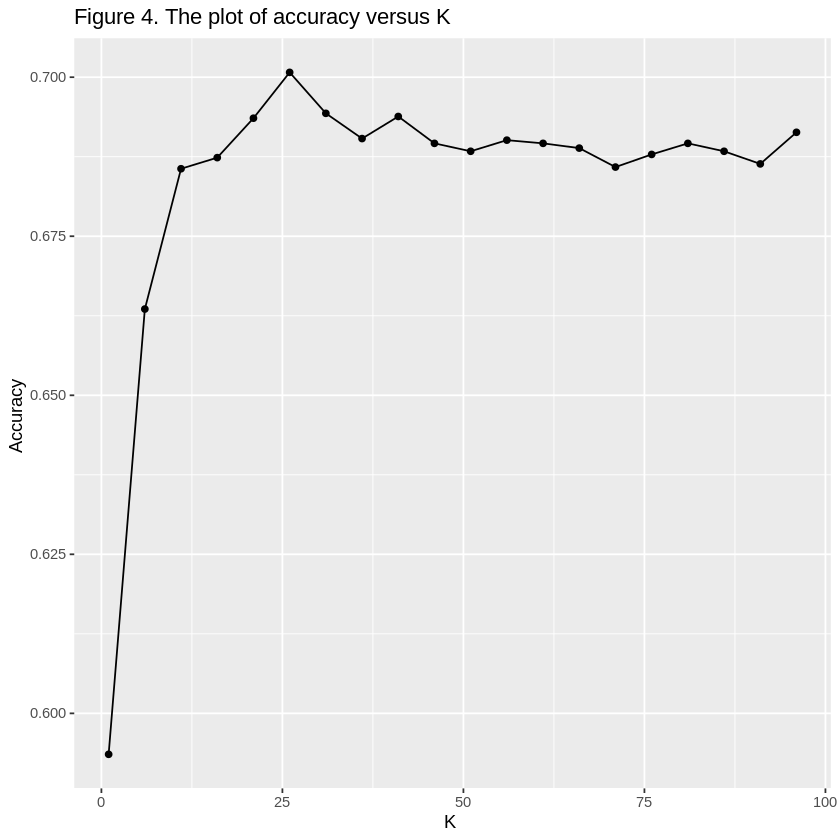

In [31]:
options(repr.plot.width = 7, repr.plot.height = 7)
set.seed(2754)

train_control <- trainControl(method = 'cv', number = 10)
ks = data.frame(k = seq(from = 1,to = 100, by = 5))
knn_model_cv_10fold <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = ks, trControl = train_control)
knn_model_cv_10fold$results

accuracy <- knn_model_cv_10fold$results
accuracy_vs_k <- accuracy %>%
    ggplot(aes(x = k, y = Accuracy))+
        geom_point()+
        geom_line()+
    labs(x='K ',y='Accuracy ',title='Figure 4. The plot of accuracy versus K')

accuracy_vs_k

Based on Figure 4, k = 26 will be used for our classification process. 

### Creating a Model Using k = 26

In [24]:
set.seed(9999) 

k = data.frame(k = 26)
knn_model <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = k,trControl = train_control)

### Computing the Accuracy Using the Test Set

In [26]:
set.seed(1236) 

X_test <- test_set %>%
    select(w_svpt, w_SvGms , l_svpt, l_SvGms) %>%
    na.omit() %>%
    data.frame()

Y_test <- test_set %>%
    select(time_classifier, w_svpt, w_SvGms, l_svpt, l_SvGms) %>%
    na.omit() %>% #This extra step ensures that no empty values are in our analysis before selecting time_classifier
    select(time_classifier) %>%
    unlist()

predictions <- predict(knn_model, X_test)
training_results <- confusionMatrix(predictions, Y_test)
training_results

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5
         1 208  50   3   0   0
         2  57 167  51   1   0
         3   3  48 161  43   1
         4   0   3  53 183  57
         5   0   0   0  41 210

Overall Statistics
                                          
               Accuracy : 0.6933          
                 95% CI : (0.6678, 0.7179)
    No Information Rate : 0.2             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6166          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity            0.7761   0.6231   0.6007   0.6828   0.7836
Specificity            0.9506   0.8983   0.9114   0.8946   0.9618
Pos Pred Value         0.7969   0.6051   0.6289   0.6182   0.8367
Neg Pred Value         0.9444   0.9051   0.9013   0.9186   0.9467
P

Our model using k = 26 showed an accuracy value of 0.6933, or 69.33%. However, we believe that the model is better than this accuracy value suggests, which will be discussed in the conclusion. We believe that 69.33% isn't a terrible accuracy, and we can analyze why the variables we chose were effective. 

The reasonings behind why the `w_svpt, w_SvGms, l_svpt, l_SvGms` variables were effective is simple: these are pure quanitity measurements. `w_svpt` and `l_svpt` purely indicate how many times each player served, while `w_SvGms` and `l_SvGms` indicate how many service games (players take turns serving for an entire 'game') the players played. These are the only statistics that aren't dictated by how the players performed during the set, this is simply a measurement of quantity- and the more serves/ service games played naturally increase the duration of the game.

We can also analyze why the accuracy was 'only' 69.33%. The most obvious reason is that the a single serve doesn't indicate how long it took a player to score in that serve- some points are scored in mere seconds, while others take much longer through an extended rally. While the number of serves/service games give a good start for our model, the data set limits it from being taken to the next level.


## Classification Analysis B: Player Profile

For classification B, we chose the rank, rank points, age, and height of both the winner and loser, then computed the difference between the winner and loser for each of those stats. An out_prime column was added, representing the difference in the winner's age from a tennis player's percieved 'prime' - 26. 

time_classifier,winner_age,loser_age,age_difference,winner_rank,loser_rank,rank_difference,winner_rank_points,loser_rank_points,rank_points_difference,winner_ht,loser_ht,height_difference,out_prime
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,29.03765,26.76523,2.272416,40,12,28,1127,2825,-1698,173,196,-23,3.0376454
1,23.14579,28.79945,-5.653662,17,56,-39,2306,816,1490,185,183,2,2.8542094
1,20.47091,28.22724,-7.756331,4,48,-44,4400,968,3432,198,181,17,5.5290897
1,26.90760,31.65503,-4.747433,80,33,47,690,1375,-685,188,185,3,0.9075975
1,26.13005,28.27652,-2.146475,5,34,-29,5085,1330,3755,185,188,-3,0.1300479
1,32.62697,31.50171,1.125257,101,114,-13,583,516,67,180,185,-5,6.6269678


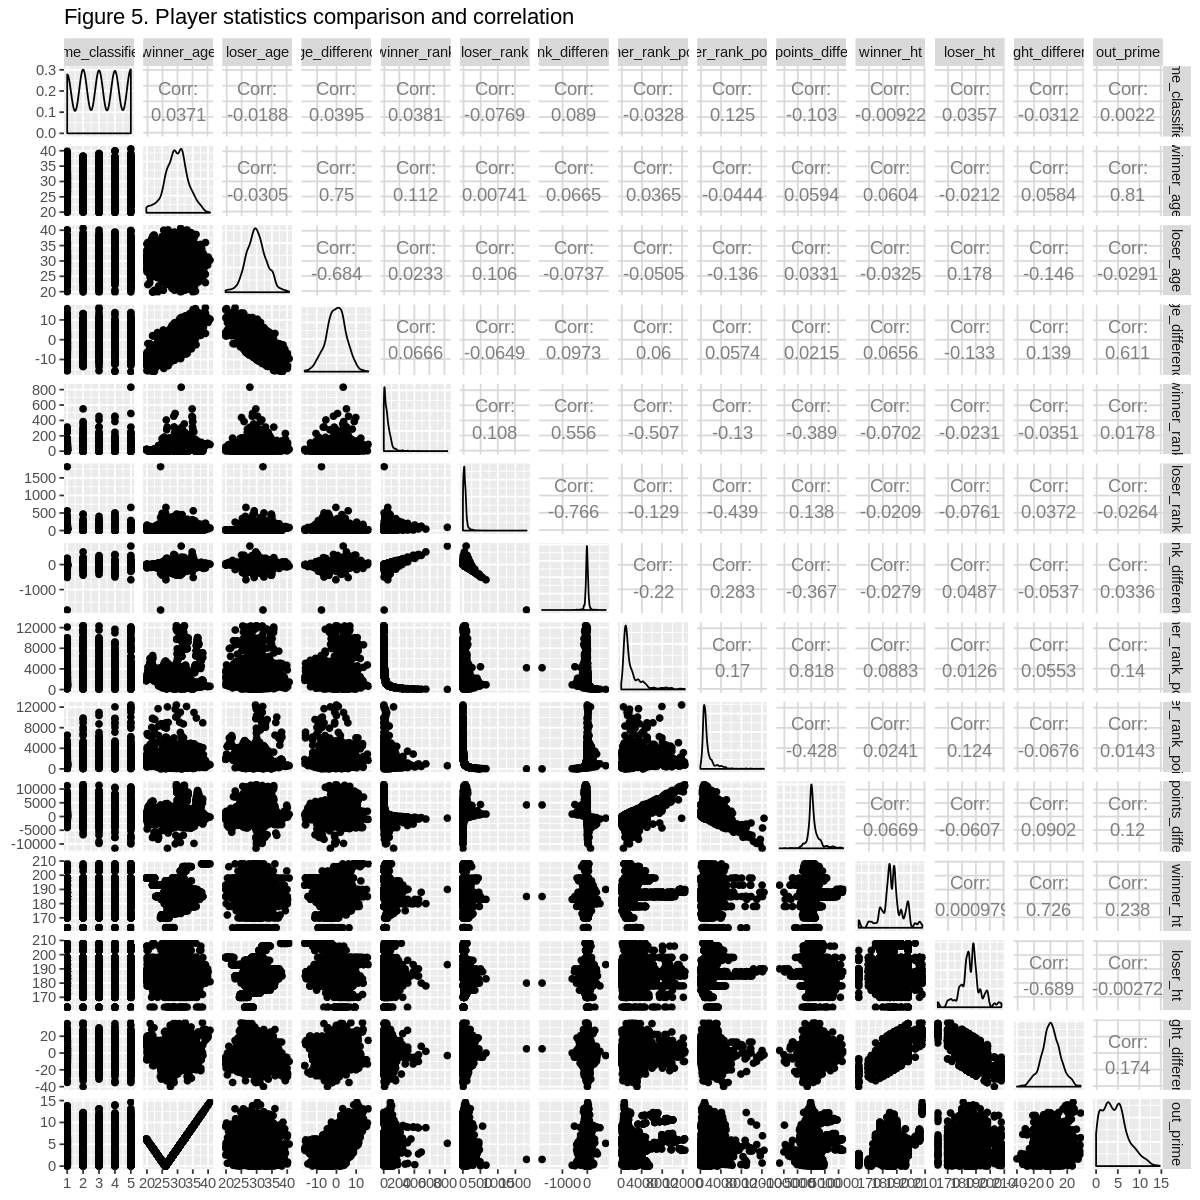

In [28]:
options(repr.plot.width = 10, repr.plot.height = 10)
    
plot_pairs <- data_sorted %>% # use ggpairs to plot player statistics with time_classifier
    mutate(time_classifier = as.numeric(time_classifier), 
           rank_difference = winner_rank - loser_rank, 
           rank_points_difference = winner_rank_points - loser_rank_points,
           age_difference = winner_age - loser_age,
           out_prime = abs(winner_age - 26),
           height_difference = winner_ht - loser_ht) %>%
    select(time_classifier, winner_age, loser_age, age_difference, winner_rank, 
           loser_rank, rank_difference, winner_rank_points, loser_rank_points, 
           rank_points_difference, winner_ht, loser_ht, height_difference, out_prime) %>% 
    na.omit()

head(plot_pairs)

plot_p <- ggpairs(plot_pairs) + ggtitle("Figure 5. Player statistics comparison and correlation")
plot_p

### Discussion

Unfortunately, running ggpairs shows little correlation between any of the variable and time_classifier. This is far from what we had expected, as we believed that the player profiles would be far better predictors compared to game stats. However, we can try to determine why the variables had poor correlation with the game time. We believe that the data we have available is far from complex enough to properly predict the game time. Part of our hypothesis was that a greater difference between the winner and loser's attributes would be indicated by a shorter game time, as it would be a 'one-sided match'. However, a professional game has many unexpected variables- unexpected delays, commercial breaks, weather, among other possibilities, that makes it impossible to predict with this limited data set. 

Thankfully, we do have the full classification performed in 'Classification Analysis A' that we can still analyze. 







## Conclusion

In conclusion, our hypothesis was very inaccurate. We learned that the in-game stats for each match were far more effective in predicting the game time, compared to the player profiles of both the winner and loser. In hindset, this makes sense- because each individual match is very different, we need detailed stats from those matches to compute a game time.

Our Classification Analysis A gave us an accuracy score of 0.6933. However, as mentioned earlier, we believe that our model is more accurate than this value suggests. Because we divided our game duration into arbitrary classes, any predictions that missed it's actual class by a small amount were deemed incorrect. Because of this, we believe that for our purposes, a regression model would be more useful in giving us a more 'accurate' accuracy value. 

Unfortunately, our model using in-game stats isn't particularly useful in a real-life scenario. In practical circumstances, t doesn't really sense to use game stats to predict game time, as it's not really "predicting" if the game has already happened. In other words, while game stats may be better predictors, it is definitely less useful in real life situations (ex. sports betting, sports analysts on television, etc.)

This project has given us an opportunity to interpret a data set and create our own hypothesis, analysis, and conclusion without concrete instructions. Due to this, we came across unexpected results in our analysis. However, we believe that our results have given us perspective on how difficult is to create a truly accurate model that fits our goals and intentions.

### References

Sackmann, Jeff. (2015). ATP Tennis Rankings, Results, and Stats. GitHub repository. https://github.com/JeffSackmann/tennis_atp 

Barnett, Tristan & Clarke, Stephen. (2005). Combining player statistics to predict outcomes of tennis matches. IMA Journal of Management Mathematics. 16. 113-120. 10.1093/imaman/dpi001. 

Bialik, Carl. (2015). Why Some Tennis Matches Take Forever. FiveThirtyEight. https://fivethirtyeight.com/features/why-some-tennis-matches-take-forever/